In [1]:
# limit compare of dt, csc, 2tag
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os
from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
# CMS_lumi.writeExtraText = 0



# donotdelete = []
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [48]:
limitTrees_csc =OrderedDict()
dataCards_csc = OrderedDict()
limitTrees_dt =OrderedDict()
dataCards_dt = OrderedDict()
limitTrees_2tag =OrderedDict()
dataCards_2tag = OrderedDict()

version = '/V1p17/v2/v138/'
dc_version = 'v1'
nrechit = 130

mode = 'allProd_withggZH'
# decay = '4Tau'
# decay = 'dddd'
decay = 'bbbb'


limitDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees_2tag/'+version+'/'+dc_version+'/'
dataCardDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards_2tag/'+version+'/'+dc_version+'/'
limitDtDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees_dt/'
dataCardDtDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards_dt/'

lumi = 137000


ctaus = np.array([10, 20, 30, 40, 100, 200, 300, 500, 600,700,800, 1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 100000,int(2e5),int(3e5),\
                        int(2e6),int(3e6),int(5e6),int(1e7)]) #v12
ctaus_dt = np.array([ 30, 100, 300, 1000, 3000,  10000, 30000, 100000,])



if decay == 'bbbb': mass = np.array([ 15, 40, 55])
else:mass = np.array([ 7, 15, 40, 55])

### limit branch: 2.5, 16.0, 50.0, 84.0, 97.5, obs
expected = ['0.025', '0.160','0.500','0.840','0.975']
dphi = 'dPhiCluster0p75'

for m in mass:
    limitTrees_csc[m] = {}
    dataCards_csc[m] = {}
    dataCards_dt[m] = {}
    limitTrees_dt[m] = {}
    dataCards_2tag[m] = {}
    limitTrees_2tag[m] = {}
    for ct in ctaus:
        name = mode+'_HToSSTo'+decay
        
        # CSC
        category = '/csc/'
        unblind = 'unblind'

        nrechit = 130
        dataCards_csc[m][ct] = dataCardDir + '/'+unblind+category+name+'_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nrechit)+dphi+'.txt'
        limitTrees_csc[m][ct] = limitDir + '/'+unblind+category+'/obs/higgsCombine.'+name+'_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nrechit)+dphi+'.AsymptoticLimits.mH120.root'
         # 2 tag
        category = '/all_cat/'
        unblind = 'blind'
        dataCards_2tag[m][ct] = dataCardDir + '/'+unblind+category+name+'_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit100.txt'
        limitTrees_2tag[m][ct] = limitDir + '/'+unblind+category+'/higgsCombine.'+name+'_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit100.AsymptoticLimits.mH120.root'

        
    for ct in ctaus_dt:
        
        # DT
        unblind = 'blind'
        dataCards_dt[m][ct] = dataCardDtDir  +'card_TH_'+str(m)+'_'+str(ct)+'_norm.txt'
        limitTrees_dt[m][ct] = limitDtDir +'/higgsCombine_card_TH_'+str(m)+'_'+str(ct)+'_norm.AsymptoticLimits.mH120.root'
        
norms = []
limits_dt = {}
limits_csc = {}
limits_2tag = {}

for i,m in enumerate(limitTrees_csc.keys()):
    limits_csc[m] = np.ones((len(ctaus), 6))*1000000
    for j, k in enumerate(limitTrees_csc[m].keys()):
#         if not os.path.isfile(dataCards_csc[m][k]):continue
#         if not os.path.isfile(limitTrees_csc[m][k]):continue

        line = open(dataCards_csc[m][k], "r").readline()
        signal_norm = float(line.split(" ")[3])
        if signal_norm == 0:continue
        if len(uproot.open(limitTrees_csc[m][k]).keys()) == 2:
            T = uproot.open(limitTrees_csc[m][k])['limit']
            if len(np.array(T.array('limit'))) == 6:limits_csc[m][j] = np.array(T.array('limit'))/signal_norm
    limits_csc[m] = np.array(limits_csc[m])
    
for i,m in enumerate(limitTrees_dt.keys()):
    limits_dt[m] = np.ones((len(ctaus), 6))*1000000
    for j, k in enumerate(limitTrees_dt[m].keys()):
        if not os.path.isfile(dataCards_dt[m][k]):continue
        if not os.path.isfile(limitTrees_dt[m][k]):continue
        line = open(dataCards_dt[m][k], "r").readline()
        if not line.split(" ")[0] == '#' :continue
        signal_norm = float(line.split(" ")[3])
        if signal_norm == 0:continue
        if len(uproot.open(limitTrees_dt[m][k]).keys()) == 2:
            T = uproot.open(limitTrees_dt[m][k])['limit']
            if len(np.array(T.array('limit'))) >= 6:limits_dt[m][j] = np.array(T.array('limit'))/signal_norm
    limits_dt[m] = np.array(limits_dt[m])    

for i,m in enumerate(limitTrees_2tag.keys()):
    limits_2tag[m] = np.ones((len(ctaus), 5))*1000000
    for j, k in enumerate(limitTrees_2tag[m].keys()):
        if not os.path.isfile(dataCards_2tag[m][k]):continue
        if not os.path.isfile(limitTrees_2tag[m][k]):continue
        line = open(dataCards_2tag[m][k], "r").readline()
        if not line.split(" ")[0] == '#' :continue
        signal_norm = float(line.split(" ")[3])
        if signal_norm == 0:continue
        if len(uproot.open(limitTrees_2tag[m][k]).keys()) == 2:
            T = uproot.open(limitTrees_2tag[m][k])['limit']
            if len(np.array(T.array('limit'))) == 5:limits_2tag[m][j] = np.array(T.array('limit'))/signal_norm
    limits_2tag[m] = np.array(limits_2tag[m])    

print(ctaus)



[      10       20       30       40      100      200      300      500
      600      700      800     1000     2000     3000     4000     5000
    10000    20000    30000   100000   200000   300000  2000000  3000000
  5000000 10000000]


# load other limit

In [ ]:
file_dir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/data/limits_others/'
ms1_40 = file_dir + 'atlas_mh125_mx40_ms1.csv'
ms2_40 = file_dir + 'atlas_mh125_mx40_ms2.csv'
id55 = file_dir + 'atlas_mh125_mx55_id.csv'
comb40 = file_dir + 'atlas_mh125_mx40_id_cr_ms2.csv'

exo_19_021_bb55 = file_dir + 'exo-19-021_bb_55.csv'
exo_19_021_bb40 = file_dir + 'exo-19-021_bb_40.csv'
exo_19_021_dd55 = file_dir + 'exo-19-021_dd_55.csv'
exo_19_021_dd40 = file_dir + 'exo-19-021_dd_40.csv'
exo_19_021_dd15 = file_dir + 'exo-19-021_dd_15.csv'


# took from paper draft v5
exo_20_003_bb55 = file_dir + 'exo-20-003_bb_55.csv'
exo_20_003_bb40 = file_dir + 'exo-20-003_bb_40.csv'
exo_20_003_bb15 = file_dir + 'exo-20-003_bb_15.csv'
exo_20_003_dd55 = file_dir + 'exo-20-003_dd_55.csv'
exo_20_003_dd40 = file_dir + 'exo-20-003_dd_40.csv'
exo_20_003_dd15 = file_dir + 'exo-20-003_dd_15.csv'


ms_40 = file_dir + 'atlas_mh125_mx40_ms.csv'
ms_15 = file_dir + 'atlas_mh125_mx15_ms.csv'
ms_8 = file_dir + 'atlas_mh125_mx8_ms.csv'


other_limits = {}

other_limits['atlas_ms_40'] = np.genfromtxt(ms_40, delimiter=',')
other_limits['atlas_ms_15'] = np.genfromtxt(ms_15, delimiter=',')
other_limits['atlas_ms_8'] = np.genfromtxt(ms_8, delimiter=',')


# 'ms1_40' = np.genfromtxt(ms1_40, delimiter=',')
# 'ms2_40' = np.genfromtxt(ms2_40, delimiter=',')
# 'id55' = np.genfromtxt(id55, delimiter=',')
# 'comb40' = np.genfromtxt(comb40, delimiter=',')
other_limits['exo_19_021_bb55'] = np.genfromtxt(exo_19_021_bb55, delimiter=',')
other_limits['exo_19_021_bb40'] = np.genfromtxt(exo_19_021_bb40, delimiter=',')
other_limits['exo_19_021_dd55'] = np.genfromtxt(exo_19_021_dd55, delimiter=',')
other_limits['exo_19_021_dd40'] = np.genfromtxt(exo_19_021_dd40, delimiter=',')
other_limits['exo_19_021_dd15'] = np.genfromtxt(exo_19_021_dd15, delimiter=',')

# other_limits['exo_20_003_bb55'] = np.genfromtxt(exo_20_003_bb55, delimiter=',')
# other_limits['exo_20_003_bb40'] = np.genfromtxt(exo_20_003_bb40, delimiter=',')
other_limits['exo_20_003_bb15'] = np.genfromtxt(exo_20_003_bb15, delimiter=',')
# other_limits['exo_20_003_dd55'] = np.genfromtxt(exo_20_003_dd55, delimiter=',')
# other_limits['exo_20_003_dd40'] = np.genfromtxt(exo_20_003_dd40, delimiter=',')
# other_limits['exo_20_003_dd15'] = np.genfromtxt(exo_20_003_dd15, delimiter=',')





# comparison of expected limit

[3.e-02 1.e-01 3.e-01 1.e+00 3.e+00 1.e+01 3.e+01 1.e+02]
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


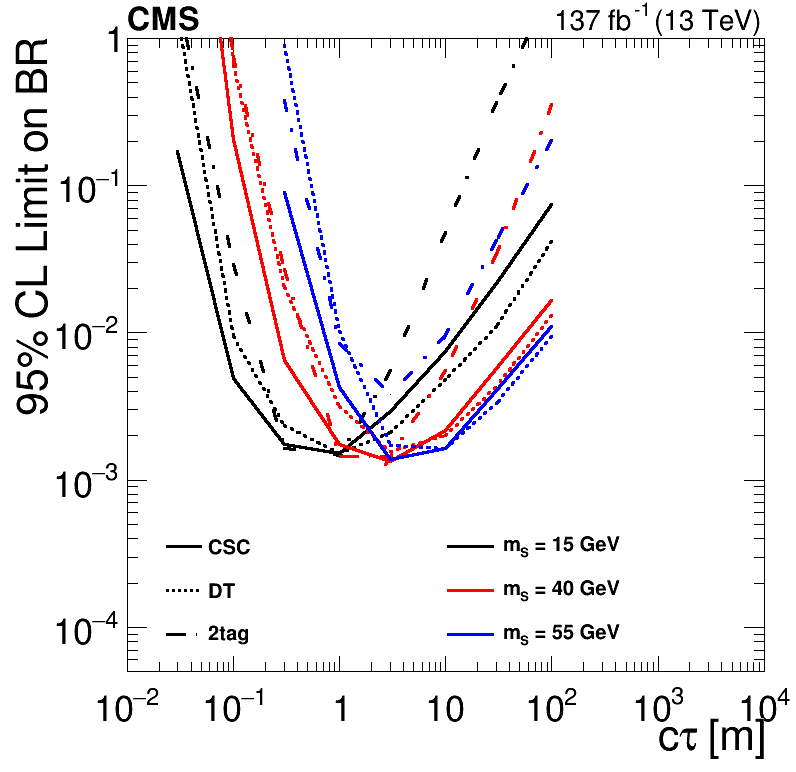

In [43]:
import os
opac_1sig = 0.25
opac_2sig = 0.1
withATLAS = 1

   


if decay == 'bbbb':
    leg = rt.TLegend(0.55,0.15,0.88,0.32)
    leg.SetTextSize(0.028)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.005)
else:
    leg = rt.TLegend(0.49,0.15,0.88,0.32)
    
    leg.SetTextSize(0.028)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.005)

leg2 = rt.TLegend(0.2,0.15,0.45,0.32)
leg2.SetTextSize(0.028)
leg2.SetBorderSize(0)
leg2.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)


rt.gStyle.SetOptFit(1011)
ctaus_m = ctaus/1000
print(ctaus_m)
h_csc = {}
h_dt = {}
h_2tag = {}
upper = 1000000


for i, m in enumerate(mass):
    cond = limits_csc[m][:,2] < 500
#     h_removeOverlap[m] = create_TGraph(ctaus_m[cond], limits_removeOverlap[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
    h_csc[m] = create_TGraph(ctaus_m[cond], limits_csc[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
    h_dt[m] = create_TGraph(ctaus_m[cond], limits_dt[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
    h_2tag[m] = create_TGraph(ctaus_m[cond], limits_2tag[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
#     print(m, ctaus_m, limits[m][:,2][cond]/limits_removeOverlap[m][:,2][cond])
#     print(m, ctaus_m, limits_removeOverlap[m][:,2][cond])


    leg.AddEntry(h_csc[m], "m_{S} = "+str(m)+" GeV", "L")
    if i == 0:
#         leg2.AddEntry(h[m], "EXO-20-015", "LP")
        leg2.AddEntry(h_csc[m], "CSC", "LP")
        leg2.AddEntry(h_dt[m], "DT", "L")
        leg2.AddEntry(h_2tag[m], "2tag", "L")
    
    h_csc[m].SetLineWidth(3)
    h_dt[m].SetLineWidth(3)
    h_2tag[m].SetLineWidth(3)
    
    h_csc[m].SetLineStyle(1)
    h_dt[m].SetLineStyle(2)
    h_2tag[m].SetLineStyle(10)
#     h[m].SetLineStyle(2)
    h_csc[m].SetLineColor(std_color_list[i])
    h_dt[m].SetLineColor(std_color_list[i])
    h_2tag[m].SetLineColor(std_color_list[i])
# #         h_others[m].SetLineStyle(2)
# #         h_others[m].SetLineWidth(3)
#     h[m].GetXaxis().SetLimits(0.01,10000.0)
    h_csc[m].GetXaxis().SetLimits(0.01,10000.0)
    h_csc[m].GetYaxis().SetRangeUser(5e-5,1)




for i,m in enumerate(h_csc.keys()):
    h_csc[m].Draw('LA' if i == 0 else 'Lsame')
    h_dt[m].Draw('LPsame')
    h_2tag[m].Draw('LPsame')



tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
iPos = 0
CMS_lumi.writeExtraText =0
CMS_lumi.extraText   = "Preliminary"

if( iPos==0 ): CMS_lumi.relPosX = 0.12
# CMS_lumi.CMS_lumi(c, 4, 0)
CMS_lumi.CMS_lumi(c, 4, iPos)

leg.Draw()
leg2.Draw()
c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)
# output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/'+unblind+'/'
# if not os.path.isdir(output_dir):os.makedirs(output_dir)
# name = output_dir+mode+'_HToSSTo'+decay+'_'+dphi+'_nRechit'+str(nrechit)+'_observed_withATLAS'
# if hybridNew:name += '_hybridNew'
# if CMS_lumi.writeExtraText: name += "_pas"



# c.SaveAs(name+'.png')
# c.SaveAs(name+'.C')
# c.SaveAs(name+'.pdf')

tdrstyle.setTDRStyle()
c.Draw()


# one mass point

[1.e-02 2.e-02 3.e-02 4.e-02 1.e-01 2.e-01 3.e-01 5.e-01 6.e-01 7.e-01
 8.e-01 1.e+00 2.e+00 3.e+00 4.e+00 5.e+00 1.e+01 2.e+01 3.e+01 1.e+02
 2.e+02 3.e+02 2.e+03 3.e+03 5.e+03 1.e+04]
length of x and y are not equal!
137 fb^{-1} (13 TeV)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


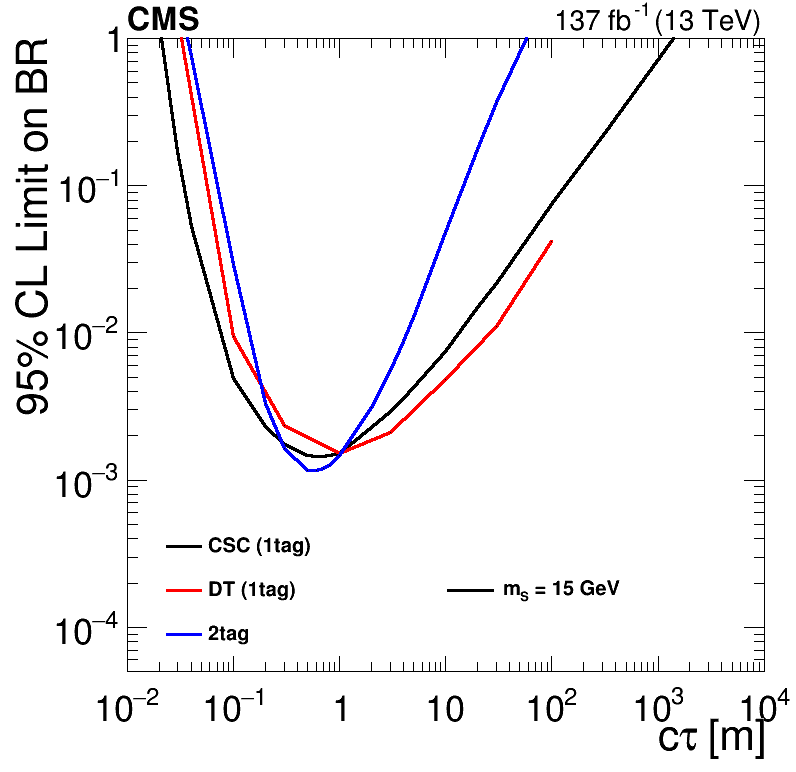

In [49]:
import os
opac_1sig = 0.25
opac_2sig = 0.1
withATLAS = 1

   


if decay == 'bbbb':
    leg = rt.TLegend(0.55,0.15,0.88,0.32)
    leg.SetTextSize(0.028)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.005)
else:
    leg = rt.TLegend(0.49,0.15,0.88,0.32)
    
    leg.SetTextSize(0.028)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.005)

leg2 = rt.TLegend(0.2,0.15,0.45,0.32)
leg2.SetTextSize(0.028)
leg2.SetBorderSize(0)
leg2.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)


rt.gStyle.SetOptFit(1011)
ctaus_m = ctaus/1000
ctaus_dt_m = ctaus_dt/1000
print(ctaus_m)
h_csc = {}
h_dt = {}
h_2tag = {}
upper = 1000000


for i, m in enumerate(mass):
    if not m == 15:continue
    cond = limits_csc[m][:,2] < 500
#     h_removeOverlap[m] = create_TGraph(ctaus_m[cond], limits_removeOverlap[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
    h_csc[m] = create_TGraph(ctaus_m[cond], limits_csc[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
    h_dt[m] = create_TGraph(ctaus_dt_m, limits_dt[m][:,2],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
    h_2tag[m] = create_TGraph(ctaus_m[cond], limits_2tag[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
#     print(m, ctaus_m, limits[m][:,2][cond]/limits_removeOverlap[m][:,2][cond])
#     print(m, ctaus_m, limits_removeOverlap[m][:,2][cond])


    leg.AddEntry(h_csc[m], "m_{S} = "+str(m)+" GeV", "L")
    if i == 0:
#         leg2.AddEntry(h[m], "EXO-20-015", "LP")
        leg2.AddEntry(h_csc[m], "CSC (1tag)", "LP")
        leg2.AddEntry(h_dt[m], "DT (1tag)", "L")
        leg2.AddEntry(h_2tag[m], "2tag", "L")
    
    h_csc[m].SetLineWidth(3)
    h_dt[m].SetLineWidth(3)
    h_2tag[m].SetLineWidth(3)
    
#     h_csc[m].SetLineStyle(1)
#     h_dt[m].SetLineStyle(2)
#     h_2tag[m].SetLineStyle(10)
    h_csc[m].SetLineColor(std_color_list[0])
    h_dt[m].SetLineColor(std_color_list[1])
    h_2tag[m].SetLineColor(std_color_list[2])
# #         h_others[m].SetLineStyle(2)
# #         h_others[m].SetLineWidth(3)
#     h[m].GetXaxis().SetLimits(0.01,10000.0)
    h_csc[m].GetXaxis().SetLimits(0.01,10000.0)
    h_csc[m].GetYaxis().SetRangeUser(5e-5,1)




for i,m in enumerate(h_csc.keys()):
    h_csc[m].Draw('LA' if i == 0 else 'Lsame')
    h_dt[m].Draw('LPsame')
    h_2tag[m].Draw('LPsame')



tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
iPos = 0
CMS_lumi.writeExtraText =0
CMS_lumi.extraText   = "Preliminary"

if( iPos==0 ): CMS_lumi.relPosX = 0.12
# CMS_lumi.CMS_lumi(c, 4, 0)
CMS_lumi.CMS_lumi(c, 4, iPos)

leg.Draw()
leg2.Draw()
c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)
# output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/'+unblind+'/'
# if not os.path.isdir(output_dir):os.makedirs(output_dir)
# name = output_dir+mode+'_HToSSTo'+decay+'_'+dphi+'_nRechit'+str(nrechit)+'_observed_withATLAS'
# if hybridNew:name += '_hybridNew'
# if CMS_lumi.writeExtraText: name += "_pas"



# c.SaveAs(name+'.png')
# c.SaveAs(name+'.C')
# c.SaveAs(name+'.pdf')

tdrstyle.setTDRStyle()
c.Draw()


# limit for different mass points

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot



# Plotting ncsc
start_t = time.time()

rt.gStyle.SetOptFit(1011)
# for i,k in enumerate(tree_bkg.keys()):
br = 1
ctaus_m = ctaus/1000
print(ctaus_m)
# print(limits[:,2])
h_others = {}
h = {}
h_exp1sig = {}
h_exp2sig = {}
h_obs = {}
for m in mass:
#     if not m == 15:continue
    print(m)
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.5,0.73,0.80,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    cond = limits[m][:,2] < 1
    h[m] = create_TGraph(ctaus_m[cond], limits[m][:,2][cond],  axis_title=['c#tau [m]', '95% CL Limit on BR'])
    if drawObs: h_obs[m] = create_TGraph(ctaus_m[cond], limits_obs[m][:,5][cond])


    h_exp1sig[m] = create_TGraph(np.hstack((ctaus_m[cond], np.flip(ctaus_m[cond]))), np.hstack((limits[m][:,1][cond], np.flip(limits[m][:,3][cond]))))
    h_exp2sig[m] = create_TGraph(np.hstack((ctaus_m[cond], np.flip(ctaus_m[cond]))), np.hstack((limits[m][:,0][cond], np.flip(limits[m][:,4][cond]))))
#
    leg.AddEntry(h[m], "Expected  95% CL upper limit", "L")
    leg.AddEntry(h_obs[m], "Observed", "PL")
    leg.AddEntry(h_exp1sig[m], "#pm 1 #sigma Expected", 'F')
    leg.AddEntry(h_exp2sig[m], "#pm 2 #sigma Expected", 'F')
    h[m].SetLineColor(std_color_list[2])
    h[m].SetLineWidth(2)
    h[m].SetLineStyle(4)


    
    h_obs[m].SetMarkerStyle(8)
    h_obs[m].SetMarkerSize(1)
    h_obs[m].SetLineColor(1)
    h_obs[m].SetLineWidth(2)
    h_exp1sig[m].SetFillColor(417)
    h_exp2sig[m].SetFillColor(800)
    h[m].GetXaxis().SetLimits(0.01,1000.0)
    h[m].GetYaxis().SetRangeUser(1e-5,100)
    h[m].GetXaxis().SetTitleOffset(1)

    h[m].Draw('LA')
    h_exp2sig[m].Draw( 'Fsame')
    h_exp1sig[m].Draw('Fsame')
    h[m].Draw('Lsame')
    h_obs[m].Draw('PLsame')

    tdrstyle.setTDRStyle()
    CMS_lumi.cmsText     = "CMS"
    iPos = 0
    CMS_lumi.writeExtraText = True
    CMS_lumi.extraText   = "Preliminary"
    iPos = 0
    if( iPos==0 ): CMS_lumi.relPosX = 0.12
    CMS_lumi.CMS_lumi(c, 4, 0)
    leg.Draw()
    c.SetRightMargin(0.03)
    c.SetLogy()
    c.SetLogx()
    c.SetTicky(1)
    c.SetTickx(1)
    c.Draw()
    output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/unblind/'
    if not os.path.isdir(output_dir):os.makedirs(output_dir)
    if VBFH:
        c.SaveAs(output_dir+'/vbfh_'+decay+'_mx'+str(m)+dphi+'_nRechit'+str(nrechit)+'.png')
        c.SaveAs(output_dir+'/vbfh_'+decay+'_mx'+str(m)+dphi+'_nRechit'+str(nrechit)+'.C')
    else:
        c.SaveAs(output_dir+'/ggh_'+decay+'_mx'+str(m)+dphi+'_nRechit'+str(nrechit)+'.png')
        c.SaveAs(output_dir+'/ggh_'+decay+'_mx'+str(m)+dphi+'_nRechit'+str(nrechit)+'.C')

# limit for different nrechits

##### load ntuples

In [ ]:
limitTrees =OrderedDict()
dataCards = OrderedDict()
version = '/V1p17/v1/v66/'
bdt_name = 'cut_based_v4'
dc_version = 'v7'
methodA = True
dphi = 'dPhiCluster0p75'
# dphi = 'dPhiJet0p6'
nRechit = 'nRechit130'
# NEW_CTAU = 60 #cm
limitDir0 = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees/'+version+'/'+bdt_name+'/'+dc_version+'/'
dataCardDir0 = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/'+version+'/'+bdt_name+'/'+dc_version+'/'
method = 1
fit_function = 'methodB/blind/'
nRechits = np.arange(60,220,10)
nRechits = np.arange(60,180,10)
nRechits = [60,70,80,90,100,120,130,135,140,145,150,155,160,170]

# dphis = np.arange(55,100,5)/100
# ctaus = np.array([5, 10, 30, 40, 50, 100, 200, 300, 500, 1000, 5000, 10000, 20000, 50000, 100000])
ctaus = np.array([1000])
masses = np.array([15, 40, 55])
ct = 1000
var = nRechits


limits = np.ones((len(masses),len(nRechits), 6))



limitDir = limitDir0 +fit_function+'/'
dataCardDir = dataCardDir0 + fit_function+'/'
for i, m in enumerate(masses):
    for j,nRechit in enumerate(var):
        limitTrees[str(nRechit)] = limitDir + 'higgsCombine.ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nRechit)+ dphi+'.AsymptoticLimits.mH120.root'
        dataCards[str(nRechit)] = dataCardDir + 'ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nRechit)+ dphi+'.txt'

    for j,k in enumerate(limitTrees.keys()):
        root_dir = uproot.open(limitTrees[k]) 
        T = root_dir['limit']
        text_file = open(dataCards[k], "r")
        line = text_file.readline()
        signal_norm = float(line.split(" ")[3])
        limits[i,j] = np.array(T.array('limit'))/signal_norm
  
    print(nRechits)


#### plot limit vs. nrechit

In [ ]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
leg = rt.TLegend(0.25,0.75,0.55,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)



c = rt.TCanvas('c','c', 900, 800)
# Plotting ncsc
start_t = time.time()

rt.gStyle.SetOptFit(1011)
h = {}
h_exp2sig = {}
h_exp1sig = {}

# for i, m in enumerate(masses):
legend = {}
legend[0] = 'scaled from intime low BDT, ABCD method'
legend[1] = 'scaled from OOT high BDT, ABCD method'
legend[2] = 'scaled from OOT high BDT, single expo'
legend[3] = 'scaled from OOT high BDT, modified expo'
legend[4] = 'scaled from OOT high BDT, single power law'





for i, m in enumerate(masses):
    
   
    h[m] = create_TGraph(var, limits[i,:,2],  axis_title=['N_{rechits} cut', '95% CL Limit on BR'])
    h_exp1sig[m] = create_TGraph(np.hstack((var, np.flip(var))), np.hstack((limits[i,:,1], np.flip(limits[i,:,3]))))
    h_exp2sig[m] = create_TGraph(np.hstack((var, np.flip(var))), np.hstack((limits[i,:,0], np.flip(limits[i,:,4]))))

    leg.AddEntry(h[m], "m_{x} = "+str(m)+" GeV, c#tau = "+str(int(ct/1000))+" m", "L")


#     leg.AddEntry(h_exp1sig, "#pm 1 #sigma Expected", 'F')
#     leg.AddEntry(h_exp2sig, "#pm 2 #sigma Expected", 'F')

#     h_exp1sig.SetFillColor(std_color_list[3])
#     h_exp2sig.SetFillColor(5)
    h[m].SetLineColor(std_color_list[i])
    h[m].SetLineWidth(2)
    h_exp1sig[m].SetFillColor(417)
    h_exp2sig[m].SetFillColor(800)
  
    
    h[m].Draw('ac' if i == 0 else 'c')
#     if m == 55:
#         h_exp2sig[m].Draw( 'Fsame')
#         h_exp1sig[m].Draw('Fsame')
    h[m].Draw('LSame')


# #     h[m].GetXaxis().SetLimits(0.5,1)
    h[m].GetXaxis().SetLimits(50,200)
    h[m].GetYaxis().SetRangeUser(1e-4,1)
#     h[m].GetXaxis().SetTitleOffset(1)

#     h_exp2sig.Draw('Fsame')
#     h_exp1sig.Draw('Fsame')
#     h.Draw('Lsame')

#     result = nRechits[np.where(limits[i,:,2] == np.amin(limits[i,:,2]))]
#     print("nRechits cut with minimum limit: ", result)




leg.Draw()
c.SetRightMargin(0.1)
c.SetLogy()
# c.SetLogx()

c.Draw()
output_dir = '/storage/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/limits/'+version+bdt_name+'/'+dc_version+'/'
c.SaveAs(output_dir+'/ggh_bbbb_scanNrechits.png')
# print(time.time()-start_t)

# limit wrt Nrechits for different methods

In [ ]:
limitTrees =OrderedDict()
dataCards = OrderedDict()
version = '/V1p17/v1/v2/'
bdt_name = 'bdt_flatten_metfilter_me1112nohits_eta2p0_testsize0p2_noSpread_v2'
methodA = True
dphi = 'dPhiCluster0p75'
nRechit = 'nRechit100'
# NEW_CTAU = 60 #cm
limitDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees/'+version+'/'+bdt_name+'/'
dataCardDir = '/storage/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/'+version+'/'+bdt_name+'/'
method = 1
fit_function = 'se'
if method == 0:
    limitDir+='methodA/'
    dataCardDir+='methodA/'
elif method == 1:
    limitDir+='methodB/'
    dataCardDir+='methodB/'
else:
    limitDir+='methodC_'+fit_function+'/'
    dataCardDir+='methodC_'+fit_function+'/'
nRechits = np.arange(60,220,10)
# dphis = np.arange(55,100,5)/100
# ctaus = np.array([5, 10, 30, 40, 50, 100, 200, 300, 500, 1000, 5000, 10000, 20000, 50000, 100000])
ctaus = np.array([1000])
masses = np.array([15, 40, 55])
ct = 1000
m = 40
var = nRechits
# limits = np.ones((len(masses),len(var), 6))
limits = np.ones((len(masses),len(nRechits), 6))


for i, m in enumerate(masses):


    for j,nRechit in enumerate(nRechits):
        limitTrees[str(nRechit)] = limitDir + 'higgsCombine.ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nRechit)+ 'dPhiCluster0p75.AsymptoticLimits.mH120.root'
        dataCards[str(nRechit)] = dataCardDir + 'ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_nRechit'+ str(nRechit)+ 'dPhiCluster0p75.txt'
#     for j,k in enumerate(dphis):
#         dphi = str(k).replace('.','p')
#         limitTrees[k] = limitDir + 'higgsCombine.ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_'+nRechit+'dPhiCluster'+str(dphi)+'.AsymptoticLimits.mH120.root'
#         dataCards[k] = dataCardDir + 'ggh_HToSSTobbbb_mh125_mx'+str(m)+'_ctau'+str(ct)+'mm_'+nRechit+'dPhiCluster'+str(dphi)+'.txt'


        
    for j,k in enumerate(limitTrees.keys()):
        root_dir = uproot.open(limitTrees[k]) 
        T = root_dir['limit']
        text_file = open(dataCards[k], "r")
        line = text_file.readline()
        signal_norm = float(line.split(" ")[3])
        limits[i,j] = np.array(T.array('limit'))/signal_norm
#         print(m,k,limits[i,j,2])
#         print(i,j, limits[i,j])
#         if i == 0: limits[i] = np.array(T.array('limit'))/signal_norm
#         else: limits[i] = np.vstack((limits[i], T.array('limit')/signal_norm))
    #     print("signal_norm",signal_norm)
#     limits = np.array(limits)
#     print(str([round(i, 5) for i in limits[:,2]])[1:-1])
    
#     result = nRechits[np.where(limits[:,2] == np.amin(limits[:,2]))]
#     print(NEW_CTAU, "nRechits cut with minimum limit: ", result)
#[0.00941727 0.00232179 0.00032019 0.0002337  0.00017991 0.00017472]
# print(limits.shape)
print(nRechits)
for i in limits[:,:,2]:
    print(str([round(j,5) for j in i])[1:-1])


